# Movie Classifier
movie genre classifier based on title and description.

## 1) Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
print(tf.config.list_physical_devices())
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from tqdm import tqdm
import time
from  ast import literal_eval
import pickle

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data_folder = "../data/archive/"

aux_folder = "./aux/"
if not os.path.exists(aux_folder):
    os.makedirs(aux_folder)

In [3]:
metadata_file = "movies_metadata.csv"
keywords_file = "keywords.csv"
credits_file = "credits.csv"

In [4]:
seed = 42

In [5]:
class DataLoader():
    """
    aux data loader wrapper class
    """
    def __init__(self, metadata_file, keywords_file, credits_file):
        """
        loads csv datasets
        """
        self.metadata_ds = pd.read_csv(os.path.join(data_folder, metadata_file), low_memory=False)
        # shuffle
        self.metadata_ds = self.metadata_ds.sample(frac = 1, random_state=seed)
        # reset index
        self.metadata_ds.reset_index(drop = True, inplace= True)
        print("metadata ds shape:\t{}".format(self.metadata_ds.shape))
        
        self.keywords_ds = pd.read_csv(os.path.join(data_folder, keywords_file), low_memory=False)
        # shuffle
        self.keywords_ds = self.keywords_ds.sample(frac = 1, random_state=seed)
        # reset index
        self.keywords_ds.reset_index(drop = True, inplace= True)
        print("keywords ds shape:\t{}".format(self.keywords_ds.shape))
        
        self.credits_ds = pd.read_csv(os.path.join(data_folder, credits_file), low_memory=False)
        # shuffle
        self.credits_ds = self.credits_ds.sample(frac = 1, random_state=seed)
        # reset index
        self.credits_ds.reset_index(drop = True, inplace= True)
        print("credits ds shape:\t{}".format(self.credits_ds.shape))

In [6]:
dl = DataLoader(metadata_file, keywords_file, credits_file)

metadata ds shape:	(45466, 24)
keywords ds shape:	(46419, 2)
credits ds shape:	(45476, 3)


## 2) E.D.A.
Explore data

In [7]:
dl.metadata_ds.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",https://www.netflix.com/title/80164212,411405,tt5717492,en,Small Crimes,"A disgraced former cop, fresh off a six-year p...",7.219022,/z7jmLmrs0pLlDU4GI6ItaJeqlET.jpg,"[{'name': 'Rooks Nest Entertainment', 'id': 34...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2017-04-28,0.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Small Crimes,False,5.8,55.0
1,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,42492,tt0069449,en,Up the Sandbox,"A young wife and mother, bored with day-to-day...",0.13845,/zwOmdqvPObv9EsMgne7EBYzPYGW.jpg,"[{'name': 'Barwood Films', 'id': 3645}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",1972-12-21,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Up the Sandbox,False,7.3,2.0
2,False,NaN,1000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,12143,tt0103759,en,Bad Lieutenant,"While investigating a young nun's rape, a corr...",6.417037,/oe8VjWCKXktqA19T1ZWtaSn8rc2.jpg,"[{'name': 'Bad Lt. Productions', 'id': 11264}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1992-09-16,2019469.0,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Gambler. Thief. Junkie. Killer. Cop.,Bad Lieutenant,False,6.9,162.0
3,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 10749, '...",NaN,9976,tt0380687,en,Satan's Little Helper,A naïve young boy unknowingly becomes the pawn...,2.233189,/59HgSvjDiaqUSYz43VZnpChgBkp.jpg,"[{'name': 'Intrinsic Value Films', 'id': 2828}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-01-01,0.0,100.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,You'll laugh 'til you die,Satan's Little Helper,False,5.0,42.0
4,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,46761,tt0157044,fr,Sitcom,The adventures of an upper-class suburban fami...,1.800582,/fZqanl6sCC29zU1K2v2mpuWyyYw.jpg,"[{'name': 'Fidélité Productions', 'id': 147}]","[{'iso_3166_1': 'FR', 'name': 'France'}]",1998-05-27,0.0,80.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Sitcom,False,6.4,27.0


In [8]:
dl.metadata_ds["overview"][0]

'A disgraced former cop, fresh off a six-year prison sentence for attempted murder - returns home looking for redemption but winds up trapped in the mess he left behind.'

In [9]:
dl.metadata_ds["genres"][0]

"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 53, 'name': 'Thriller'}, {'id': 80, 'name': 'Crime'}]"

In [10]:
dl.keywords_ds.head(5)

,id,keywords
0,16997,"[{'id': 156786, 'name': 'prison escape'}, {'id..."
1,46548,[]
2,50028,"[{'id': 187056, 'name': 'woman director'}]"
3,259550,"[{'id': 12425, 'name': 'racism'}, {'id': 14514..."
4,34474,"[{'id': 74, 'name': 'germany'}, {'id': 549, 'n..."


In [11]:
dl.credits_ds.head(5)

,cast,crew,id
0,"[{'cast_id': 4, 'character': 'David Marx', 'cr...","[{'credit_id': '5630aa66c3a3681b5c00f74e', 'de...",41366
1,"[{'cast_id': 1, 'character': ""Eduardo 'Eddie' ...","[{'credit_id': '59379c1fc3a36827dd000b2f', 'de...",460846
2,"[{'cast_id': 9, 'character': 'Paul', 'credit_i...","[{'credit_id': '52fe421dc3a36847f8005383', 'de...",143
3,"[{'cast_id': 2, 'character': 'Oreste Jacovacci...","[{'credit_id': '5648d02dc3a3682605007df6', 'de...",55823
4,"[{'cast_id': 1, 'character': 'Nathalie', 'cred...","[{'credit_id': '52fe46b79251416c9105d4fd', 'de...",38414


## 3) NLP preproc
I choose to leverage only metadata overview + title + tagline to performe classification inference on the genres.

In [12]:
features = ["original_title", "overview", "tagline"]
target = "genres"

In [13]:
# check nans
dl.metadata_ds.drop([c for c in dl.metadata_ds.columns if c not in features+[target]],axis=1, inplace=True)
dl.metadata_ds.isna().sum()

genres                0
original_title        0
overview            954
tagline           25054
dtype: int64

In [14]:
# replace nans with empty strings
dl.metadata_ds.fillna("", inplace=True)

In [15]:
dl.metadata_ds[features]

,original_title,overview,tagline
0,Small Crimes,"A disgraced former cop, fresh off a six-year p...",
1,Up the Sandbox,"A young wife and mother, bored with day-to-day...",
2,Bad Lieutenant,"While investigating a young nun's rape, a corr...",Gambler. Thief. Junkie. Killer. Cop.
3,Satan's Little Helper,A naïve young boy unknowingly becomes the pawn...,You'll laugh 'til you die
4,Sitcom,The adventures of an upper-class suburban fami...,
...,...,...,...
45461,Streamers,Four young recruits about to be sent to Vietna...,
45462,Farmer Al Falfa Sees New York,"Farmer Al Falfa goes to New York, money bag in...",
45463,A Cry in the Wilderness,The father of a wilderness family gets bitten ...,
45464,Talk of Angels,This is the story of a young Irish woman who c...,


In [16]:
dl.metadata_ds[target]

0        [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...
1        [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...
2        [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...
3        [{'id': 27, 'name': 'Horror'}, {'id': 10749, '...
4        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
                               ...                        
45461                        [{'id': 18, 'name': 'Drama'}]
45462                    [{'id': 16, 'name': 'Animation'}]
45463    [{'id': 53, 'name': 'Thriller'}, {'id': 10770,...
45464    [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...
45465    [{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...
Name: genres, Length: 45466, dtype: object

In [17]:
# merge descriptions columns into desc
dl.metadata_ds["desc"] = dl.metadata_ds["original_title"]+" "+dl.metadata_ds["overview"]+\
                         " "+ dl.metadata_ds["tagline"]
dl.metadata_ds.drop(features, axis = 1, inplace=True)
dl.metadata_ds

,genres,desc
0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...","Small Crimes A disgraced former cop, fresh off..."
1,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...","Up the Sandbox A young wife and mother, bored ..."
2,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",Bad Lieutenant While investigating a young nun...
3,"[{'id': 27, 'name': 'Horror'}, {'id': 10749, '...",Satan's Little Helper A naïve young boy unknow...
4,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Sitcom The adventures of an upper-class suburb...
...,...,...
45461,"[{'id': 18, 'name': 'Drama'}]",Streamers Four young recruits about to be sent...
45462,"[{'id': 16, 'name': 'Animation'}]",Farmer Al Falfa Sees New York Farmer Al Falfa ...
45463,"[{'id': 53, 'name': 'Thriller'}, {'id': 10770,...",A Cry in the Wilderness The father of a wilder...
45464,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",Talk of Angels This is the story of a young Ir...


In [18]:
# split train test
train_perc = 0.8
max_train_ind = int(dl.metadata_ds.shape[0]*train_perc)

train_set = dl.metadata_ds.iloc[:max_train_ind]
valid_test_set = dl.metadata_ds.iloc[max_train_ind:]
print("train set shape:\t{}\nvalid-test set shape:\t{}".format(train_set.shape, valid_test_set.shape))

train set shape:	(36372, 2)
valid-test set shape:	(9094, 2)


One Hot Encode target genres

In [19]:
# check target cardinality
tgt_set = set()
for e in tqdm(train_set[target]):
    for g in literal_eval(e):
        tgt_set.add(g["name"])

100%|██████████| 36372/36372 [00:00<00:00, 59835.81it/s]


In [20]:
num_genres = len(tgt_set)
num_genres

32

In [21]:
id_genres_dict = dict()
genres_id_dict = dict()
for e in enumerate(tgt_set):
    id_genres_dict[e[0]]=e[1]
    genres_id_dict[e[1]]=e[0]
    
# saving
with open(os.path.join(aux_folder, "id_genres_dict_{}.pkl".format(
    str(time.time()).replace(".", "_"))), 'wb') as f:
    pickle.dump(id_genres_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(aux_folder, "genres_id_dict_{}.pkl".format(str(
    time.time()).replace(".", "_"))), 'wb') as f:
    pickle.dump(genres_id_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
id_genres_dict

{0: 'Crime',
 1: 'Horror',
 2: 'TV Movie',
 3: 'Odyssey Media',
 4: 'Western',
 5: 'Animation',
 6: 'Vision View Entertainment',
 7: 'Drama',
 8: 'Telescene Film Group Productions',
 9: 'Mardock Scramble Production Committee',
 10: 'Pulser Productions',
 11: 'Romance',
 12: 'Foreign',
 13: 'Science Fiction',
 14: 'Comedy',
 15: 'Sentai Filmworks',
 16: 'Carousel Productions',
 17: 'Aniplex',
 18: 'The Cartel',
 19: 'Family',
 20: 'Adventure',
 21: 'Mystery',
 22: 'Fantasy',
 23: 'War',
 24: 'History',
 25: 'Action',
 26: 'Rogue State',
 27: 'Documentary',
 28: 'Music',
 29: 'GoHands',
 30: 'BROSTA TV',
 31: 'Thriller'}

In [23]:
genres_id_dict

{'Crime': 0,
 'Horror': 1,
 'TV Movie': 2,
 'Odyssey Media': 3,
 'Western': 4,
 'Animation': 5,
 'Vision View Entertainment': 6,
 'Drama': 7,
 'Telescene Film Group Productions': 8,
 'Mardock Scramble Production Committee': 9,
 'Pulser Productions': 10,
 'Romance': 11,
 'Foreign': 12,
 'Science Fiction': 13,
 'Comedy': 14,
 'Sentai Filmworks': 15,
 'Carousel Productions': 16,
 'Aniplex': 17,
 'The Cartel': 18,
 'Family': 19,
 'Adventure': 20,
 'Mystery': 21,
 'Fantasy': 22,
 'War': 23,
 'History': 24,
 'Action': 25,
 'Rogue State': 26,
 'Documentary': 27,
 'Music': 28,
 'GoHands': 29,
 'BROSTA TV': 30,
 'Thriller': 31}

In [24]:
def genres_to_ohe(g, num_g=num_genres):
    """
    one hot encodes genres string g
    """
    ohe = np.zeros(num_g, dtype = int)
    gs = literal_eval(g)
    for g in gs:
        try:
            ohe[genres_id_dict[g["name"]]]=1
        except KeyError: # validation unseen genre
            pass
    return ohe

In [25]:
%%time
# ohe target
dl.metadata_ds[target] = dl.metadata_ds[target].apply(lambda x: genres_to_ohe(x))

CPU times: user 791 ms, sys: 0 ns, total: 791 ms
Wall time: 790 ms


In [26]:
train_set

,genres,desc
0,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","Small Crimes A disgraced former cop, fresh off..."
1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","Up the Sandbox A young wife and mother, bored ..."
2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",Bad Lieutenant While investigating a young nun...
3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",Satan's Little Helper A naïve young boy unknow...
4,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",Sitcom The adventures of an upper-class suburb...
...,...,...
36367,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Tom and Jerry Meet Sherlock Holmes Tom and Jer...
36368,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","スレイヤーズ ぐれえと Lina and Naga, on their way to a t..."
36369,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","شکارچی In an act of vengeance, a young man ran..."
36370,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","Middle Man When a hapless, unfunny, wanna-be c..."


In [27]:
valid_test_set

,genres,desc
36372,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",Fjorton suger Fourteen-year-old Emma goes to a...
36373,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Religulous Commentator-comic Bill Maher plays ...
36374,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The Poughkeepsie Tapes When hundreds of videot...
36375,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",One Week Ben Tyler (Joshua Jackson) has been d...
36376,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Catwoman Liquidated after discovering a corpor...
...,...,...
45461,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",Streamers Four young recruits about to be sent...
45462,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Farmer Al Falfa Sees New York Farmer Al Falfa ...
45463,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",A Cry in the Wilderness The father of a wilder...
45464,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",Talk of Angels This is the story of a young Ir...


In [28]:
X_train = train_set["desc"]
y_train = train_set["genres"]

X_valid = valid_test_set["desc"]
y_valid = valid_test_set["genres"]

y_train = np.array([list(x) for x in y_train.values])
y_valid = np.array([list(x) for x in y_valid.values])

print("X_train shape:\t{}\ny_train shape:\t{}\nX_valid shape:\t{}\ny_valid shape:\t{}".format(
    X_train.shape, y_train.shape, X_valid.shape, y_valid.shape))

X_train shape:	(36372,)
y_train shape:	(36372, 32)
X_valid shape:	(9094,)
y_valid shape:	(9094, 32)


## 4) Model
sequence learning nlp rnn

### tokenization

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [30]:
%%time
VOCAB_SIZE = 10000 # max num of tokens
tok = Tokenizer(VOCAB_SIZE)
tok.fit_on_texts(X_train)
X_train = tok.texts_to_sequences(X_train)
X_valid = tok.texts_to_sequences(X_valid)

CPU times: user 2.48 s, sys: 22.2 ms, total: 2.5 s
Wall time: 2.5 s


### pad sequences

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
X_train = pad_sequences(X_train, padding='post', truncating='post') # pad to longest seq
print(X_train.shape)
X_pad_len = X_train.shape[1]
print(X_pad_len)
X_valid = pad_sequences(X_valid, maxlen=X_pad_len, padding='post', truncating='post')
print("X_train shape:\t{}\nX_valid shape:\t{}".format(
    X_train.shape, X_valid.shape))

(36372, 186)
186
X_train shape:	(36372, 186)
X_valid shape:	(9094, 186)


### Embedding and Processing

In [33]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Flatten, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [35]:
def plot_hist(hist):
    """
    plots train and val accs during training
    """
    plt.figure(figsize=(10, 7.5))
    plt.plot(hist.history["accuracy"], color = "blue", label = "train_acc")
    plt.plot(hist.history["val_accuracy"], color = "orange", label = "valid acc")
    plt.legend()
    plt.xlabel("epochs");

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 186)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 186, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 186, 50)           35800     
_________________________________________________________________
flatten (Flatten)            (None, 9300)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9300)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                297632    
Total params: 1,613,432
Trainable params: 1,613,432
Non-trainable params: 0
___________________________________________________

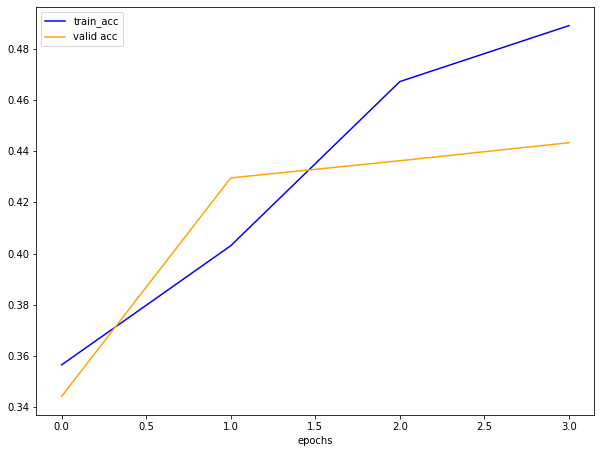

In [36]:
# model definition 10k vocab
model_input = Input(shape = [X_pad_len])

emb = Embedding(input_dim = VOCAB_SIZE, output_dim = 128)(model_input)
sLSTM = LSTM(50, activation = 'tanh', kernel_initializer = 'he_normal',
             return_sequences = True, activity_regularizer=l1(0.001))(emb)
flat = Flatten()(sLSTM)
do = Dropout(0.3)(flat)
model_output = Dense(num_genres, activation = "sigmoid")(do)

model1 = Model(model_input, model_output)

model1.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model1.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
hist1 = model1.fit(X_train, y_train, batch_size=64, epochs=4, validation_data = (X_valid, y_valid),
                  callbacks = [callback])
plot_hist(hist1)

In [37]:
def test_pred(model, tok, conf_threshold = 0.3):
    title = input("insert title please:\n")
    description = input("insert description please:\n")
    merged_desc = str(title)+" "+str(description)
    tok_inp = tok.texts_to_sequences([merged_desc])
    pad_inp = pad_sequences(tok_inp, maxlen=model1.input_shape[1], padding='post', truncating='post')
    pred = np.array(model1.predict(pad_inp)).flatten()
    pred_g = np.argwhere(pred>conf_threshold).flatten()
    if len(pred_g)==0:
        pred_g = np.argmax(pred).flatten()
    print()
    for g in pred_g:
        print(id_genres_dict[g])

In [38]:
test_pred(model1, tok)

insert title please:
kill everyone
insert description please:
serial kill seeking vengeance

Thriller


In [39]:
test_pred(model1, tok)

insert title please:
love me baby!!
insert description please:
love story for teenagers and families

Drama
Comedy


In [40]:
test_pred(model1, tok)

insert title please:
eevee the amazing cat
insert description please:
a wonderful cat and her adventure while conquering the worlfd

Comedy
Family


## 4) Serialize Models
Store trained model and tokenizer on disk.

In [41]:
from tensorflow import keras

In [42]:
models_folder = "../models/"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
model_path = os.path.join(models_folder, "model1_{}".format(str(time.time()).replace(".", "_")))
model1.save(model_path)

INFO:tensorflow:Assets written to: ../models/model1_1623170131_5833135/assets


INFO:tensorflow:Assets written to: ../models/model1_1623170131_5833135/assets


In [43]:
tok_name = "tok_{}".format(str(time.time()).replace(".", "_"))
tok_path = os.path.join(models_folder, tok_name)
# saving
with open(tok_path, 'wb') as f:
    pickle.dump(tok, f, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
# test load models
models_folder = "../models"
tok_name = "tok_1623165732_332077"
tok_path = os.path.join(models_folder, tok_name)

with open(tok_path, 'rb') as f:
    loaded_tok = pickle.load(f)

model_name = "model1_1623165604_9715395"
model_path = os.path.join(models_folder, model_name)

loaded_model1 = keras.models.load_model(model_path)

In [45]:
test_pred(loaded_model1, loaded_tok)

insert title please:
test music
insert description please:
musical bands songs test

Comedy
Family
Documentary
Music


## Test Wrapper
required libraries: (py3), (os), pickle, tensorflow, numpy

In [46]:
import os
import pickle
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [47]:
def test_pred(model, tok, conf_threshold = 0.3):
    cont = 'y'
    while cont!='n':
        title = input("insert title please:\n")
        description = input("insert description please:\n")
        merged_desc = str(title)+" "+str(description)
        tok_inp = tok.texts_to_sequences([merged_desc])
        pad_inp = pad_sequences(tok_inp, maxlen=model.input_shape[1], padding='post', truncating='post')
        pred = np.array(model.predict(pad_inp)).flatten()
        pred_g = np.argwhere(pred>conf_threshold).flatten()
        if len(pred_g)==0:
            pred_g = np.argmax(pred).flatten()
        print()
        genres = ""
        for g in pred_g:
            genres+="{}, ".format(id_genres_dict[g])
        genres = genres[:-2]
        out_dict = {"title": title, "description": description, "genre": genres}
        print(out_dict)
        cont = None
        while cont not in ["y", "n"]:
            cont = input("continue? [y/n]\n")

In [50]:
# load models
models_folder = "../models"
tok_name = "tok_1623170133_8569906"
tok_path = os.path.join(models_folder, tok_name)

aux_folder = "./aux/"

with open(tok_path, 'rb') as f:
    loaded_tok = pickle.load(f)

# load genres dict
with open(os.path.join(aux_folder, "id_genres_dict_1623170035_963645.pkl"), 'rb') as f:
    id_genres_dict = pickle.load(f)

model_name = "model1_1623170131_5833135"
model_path = os.path.join(models_folder, model_name)

loaded_model1 = keras.models.load_model(model_path)

test_pred(loaded_model1, loaded_tok)

insert title please:
the super pickle model
insert description please:
an amazing pickle with super powers fighting every machine learning problem

{'title': 'the super pickle model', 'description': 'an amazing pickle with super powers fighting every machine learning problem', 'genre': 'Animation, Comedy, Family'}
continue? [y/n]
n
